In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
import tensorflow as tf
from keras.models import Model
import sklearn.datasets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
import os, cv2
train_path = '/content/drive/My Drive/dataset/'
train_data = os.listdir(train_path)
X_train = []
for img in train_data:
    img_path = train_path+img
    x = cv2.imread(img_path, 0)
    x = cv2.resize(x, (256, 256), interpolation=cv2.INTER_CUBIC)
    X_train.append(x)

In [ ]:
X = X_train
X.shape

(4738, 256, 256, 1)

In [ ]:
X_train = np.array(X_train)
X_train.shape

(4738, 256, 256)

In [ ]:
X_train = X_train.astype('float32') / 255.
X_train = np.reshape(X_train, (-1, 256, 256, 1))
X_train.shape

(4738, 256, 256, 1)

In [ ]:
input_img = Input(shape=(256,256,1))
x = Conv2D(256,(3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(128,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(32,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(16,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same', name='encoder')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 256, 256, 256)     2560      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 256)     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 128)     295040    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 64)        73792     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)       

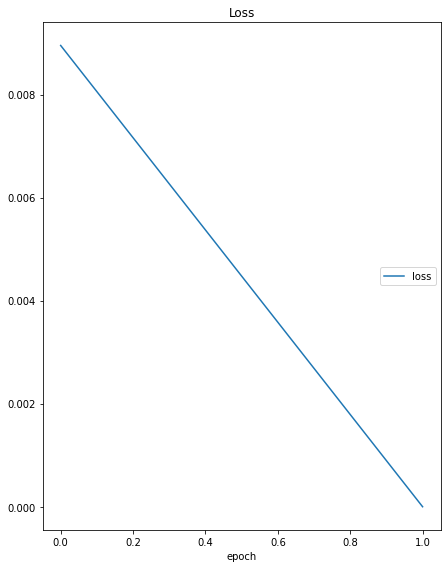

Loss
	loss             	 (min:    0.000, max:    0.009, cur:    0.000)
149/149 [==============================] - 105s 706ms/step - loss: 6.3458e-11


In [ ]:
from livelossplot import PlotLossesKeras
autoencoder.fit(X_train, X_train, epochs=2, batch_size=32, callbacks=[PlotLossesKeras()] )

In [ ]:
autoencoder.save('/content/drive/My Drive/models/autoencoder3.h5')

In [ ]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
encoder.save('/content/drive/My Drive/models/encoder3.h5')

In [ ]:
img_ip = str(input("Enter image path: "))
#img_ip = '/content/drive/My Drive/queries/q1.jpg'
query = cv2.imread(img_ip, 0)
query = cv2.resize(query, (256,256), interpolation=cv2.INTER_CUBIC)
query = np.array(query)
query = query.astype('float32') / 255.
query = np.reshape(query, (-1, 256, 256, 1))
query.shape

Enter image path: /content/drive/My Drive/queries/q1.jpg


(1, 256, 256, 1)

In [ ]:
codes = encoder.predict(X_train)
codes.shape

(4738, 4, 4, 8)

In [ ]:
query_code = encoder.predict(query)
query_code.shape

(1, 4, 4, 8)

In [ ]:
codes = codes.reshape(-1, 4*4*8)
print(codes.shape)
query_code = query_code.reshape(1, 4*4*8)
print(query_code.shape)

(4738, 128)
(1, 128)


In [ ]:
from sklearn.neighbors import NearestNeighbors
n_neigh = int(input("Enter N: "))
nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)

Enter N: 5


In [ ]:
distances, indices = nbrs.kneighbors(np.array(query_code))
similar_imgs = train_data[indices]

In [ ]:
print(indices)
print(similar_imgs)

[[4303  977 3352  125 3573]]
[['2976.jpg' '4212.jpg' '1726.jpg' '2191.jpg' '1076.jpg']]


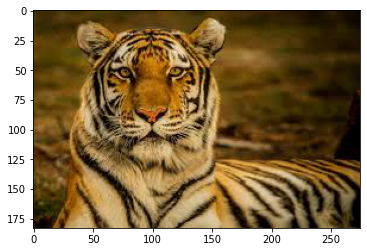

In [ ]:
plt.imshow(mpimg.imread(img_ip))

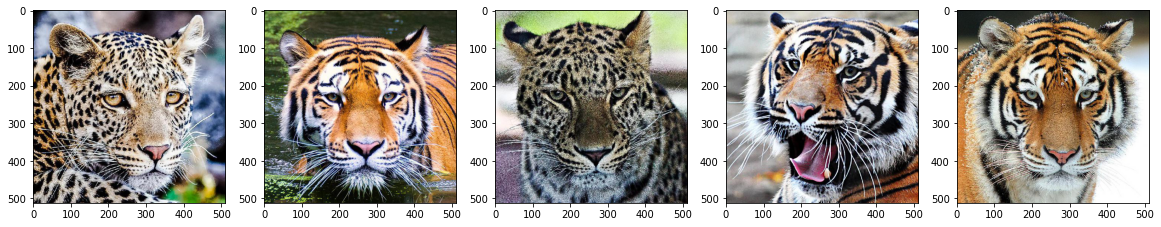

In [ ]:
plt.figure(figsize=(20, 6))
for i in range(n_neigh):
    # display similar images
    ax = plt.subplot(1, n_neigh, i+1)
    plt.imshow(mpimg.imread(train_path+similar_imgs[0][i]))
plt.show()

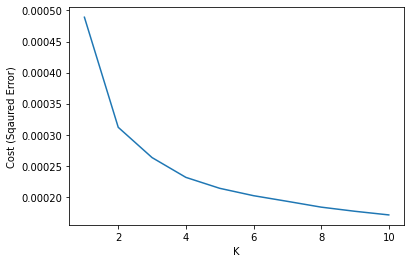

In [162]:
from sklearn.cluster import KMeans 

cost =[] 
for i in range(1, 11): 
	  KM = KMeans(n_clusters = i, max_iter = 500) 
	  KM.fit(codes)  
	  cost.append(KM.inertia_)	#compute squared error for the clustered points 

#plot cost against K value
plt.plot(range(1, 11), cost) 
plt.xlabel("K") 
plt.ylabel("Cost (Sqaured Error)") 
plt.show() 

#the point of the elbow is the optimal value of K 

In [163]:
#choose K=2, 3 or 4
kmeans = KMeans(n_clusters=4).fit(codes)
clusters = kmeans.labels_
print(clusters)

[3 3 3 ... 2 1 1]


Enter start index: 0
Enter stop index: 20


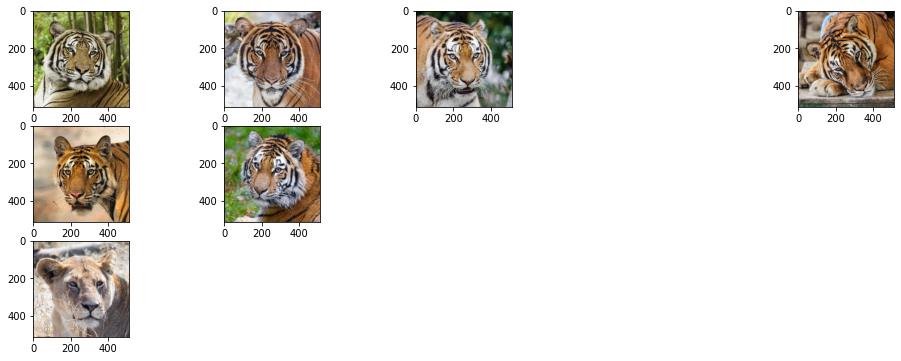

In [168]:
plt.figure(figsize=(20, 6))
first = int(input('Enter start index: '))
last = int(input('Enter stop index: '))
for i in range(first, last):
    code = codes[i]
    group = kmeans.predict(code.reshape(-1, 128))
    if group==3:
    #display similar images
        ax = plt.subplot(3, (last-first)//3, i+1)
        plt.imshow(mpimg.imread(train_path+train_data[i]))
plt.show()